In [1]:
"""
Create Train and Test Files for the DDI experiment
"""
def createFile(filepath, outputpath):
    fOut = open(outputpath, 'w')
    lines = [line.strip() for line in open(filepath)]
    for idx in xrange(0, len(lines)):
        sentence = lines[idx].split("\t")[0]
        label = lines[idx].split("\t")[1].split("\n")[0].split("\r")[0]
        
        sentence = sentence.replace("<e1>", " _e1_ ").replace("</e1>", " _/e1_ ")
        sentence = sentence.replace("<e2>", " _e2_ ").replace("</e2>", " _/e2_ ")
        tokens = nltk.word_tokenize(sentence)
        
        n_tokens = []
        idx_j = 0
        
        while idx_j < len(tokens):
            if tokens[idx_j] == "_e1_":
                n_tokens.append(tokens[idx_j])
                e1_word = ""
                idx_k = idx_j + 1
                while idx_k < len(tokens):
                    idx_j += 1
                    if tokens[idx_k] == "_/e1_":
                        break
                    e1_word += tokens[idx_k] + "_"
                    idx_k += 1
                e1_word = e1_word[:-1]
                n_tokens.append(e1_word)  
            
            elif tokens[idx_j] == "_e2_":
                n_tokens.append(tokens[idx_j])
                e2_word = ""
                idx_k = idx_j + 1
                while idx_k < len(tokens):
                    idx_j += 1
                    if tokens[idx_k] == "_/e2_":
                        break
                    e2_word += tokens[idx_k] + "_"
                    idx_k += 1
                e2_word = e2_word[:-1]
                n_tokens.append(e2_word)
            
            else:
                n_tokens.append(tokens[idx_j])
            idx_j += 1
        
        #n_tokens.remove('_/e1_')    
        #n_tokens.remove('_/e2_')
        
        e1 = n_tokens.index("_e1_")
        del n_tokens[e1]
        
        e2 = n_tokens.index("_e2_")
        del n_tokens[e2]
    
        #if "None" not in label:
        fOut.write("\t".join([label, str(e1), str(e2), " ".join(n_tokens)]))
        fOut.write("\n")
    fOut.close()

In [2]:
import nltk
trainFile = 'Train/DrugBank.txt'
testFile = 'Train/Medline.txt'

createFile(trainFile, "files/train_ddi.txt")
createFile(testFile, "files/test_ddi.txt")

print "Train / Test file created"

Train / Test file created


In [3]:
def createMatrices(file, word2Idx, maxSentenceLen=100):
    """Creates matrices for the events and sentence for the given file"""
    labels = []
    positionMatrix1 = []
    positionMatrix2 = []
    tokenMatrix = []
    
    for line in open(file):
        splits = line.strip().split('\t')
        
        label = splits[0]
        pos1 = splits[1]
        pos2 = splits[2]
        sentence = splits[3]
        tokens = sentence.split(" ")
        
        labelsDistribution[label] += 1
      
        
        tokenIds = np.zeros(maxSentenceLen)
        positionValues1 = np.zeros(maxSentenceLen)
        positionValues2 = np.zeros(maxSentenceLen)
        
        for idx in xrange(0, min(maxSentenceLen, len(tokens))):
            tokenIds[idx] = getWordIdx(tokens[idx], word2Idx)
            
            distance1 = idx - int(pos1)
            distance2 = idx - int(pos2)
            
            if distance1 in distanceMapping:
                positionValues1[idx] = distanceMapping[distance1]
            elif distance1 <= minDistance:
                positionValues1[idx] = distanceMapping['LowerMin']
            else:
                positionValues1[idx] = distanceMapping['GreaterMax']
                
            if distance2 in distanceMapping:
                positionValues2[idx] = distanceMapping[distance2]
            elif distance2 <= minDistance:
                positionValues2[idx] = distanceMapping['LowerMin']
            else:
                positionValues2[idx] = distanceMapping['GreaterMax']
            
        tokenMatrix.append(tokenIds)
        positionMatrix1.append(positionValues1)
        positionMatrix2.append(positionValues2)
        
        labels.append(labelsMapping[label])
        

    
    return np.array(labels, dtype='int32'), np.array(tokenMatrix, dtype='int32'), np.array(positionMatrix1, dtype='int32'), np.array(positionMatrix2, dtype='int32'),

In [4]:
def getWordIdx(token, word2Idx): 
    """Returns from the word2Idex table the word index for a given token"""       
    if token in word2Idx:
        return word2Idx[token]
    elif token.lower() in word2Idx:
        return word2Idx[token.lower()]
    
    return word2Idx["UNKNOWN"]

In [5]:
import gensim
W2V_model = gensim.models.KeyedVectors.load_word2vec_format('/home/akshay/notebooks/Relation CNN/code/GoogleNews-vectors-negative300.bin', binary=True)
vocab = list(W2V_model.vocab.keys())

In [6]:
import numpy as np
import cPickle as pkl
from nltk import FreqDist
import gzip

outputFilePath = 'pkl/sem-relations.pkl.gz'
embeddingsPklPath = 'pkl/embeddings.pkl.gz'

folder = 'files/'
files = [folder + 'train_ddi.txt', folder + 'test_ddi.txt']

#Mapping of the labels to integers
labelsMapping = {'None(e1,e2)' : 0, 
                 'effect(e1,e2)' : 1, 
                 'advise(e1,e2)' : 2, 
                 'mechanism(e1,e2)' : 3,
                 'int(e1,e2)' : 4}

words = {}
maxSentenceLen = [0,0,0]
labelsDistribution = FreqDist()

distanceMapping = {'PADDING': 0, 'LowerMin': 1, 'GreaterMax': 2}
minDistance = -30
maxDistance = 30
for dis in xrange(minDistance,maxDistance+1):
    distanceMapping[dis] = len(distanceMapping)


for fileIdx in xrange(len(files)):
    file = files[fileIdx]
    print files[fileIdx]
    for line in open(file):
        splits = line.strip().split('\t')
        
        label = splits[0]
        
        sentence = splits[3]  
        tokens = sentence.split(" ")
        maxSentenceLen[fileIdx] = max(maxSentenceLen[fileIdx], len(tokens))
        for token in tokens:
            words[token.lower()] = True
    print len(words)

print "Max Sentence Lengths: ", maxSentenceLen, len(words)
        
# :: Read in word embeddings ::
word2Idx = {}
embeddings = []
count = 0
for index, word in enumerate(vocab):
    if len(word2Idx) == 0: #Add padding+unknown
        word2Idx["PADDING"] = len(word2Idx)
        vector = np.zeros(300) #Zero vector vor 'PADDING' word
        embeddings.append(vector)
        
        word2Idx["UNKNOWN"] = len(word2Idx)
        vector = np.random.uniform(-0.25, 0.25, 300)
        embeddings.append(vector)

    if word.lower() in words and word.lower() not in word2Idx:
        vector = np.array(W2V_model[word])
        embeddings.append(vector)
        word2Idx[word.lower()] = len(word2Idx)
        count += 1
        
embeddings = np.array(embeddings)

print "Embeddings shape: ", embeddings.shape
print "Len words: ", len(words), count

f = gzip.open(embeddingsPklPath, 'wb')
pkl.dump(embeddings, f, -1)
f.close()

# :: Create token matrix ::
train_set = createMatrices(files[0], word2Idx, max(maxSentenceLen))
test_set = createMatrices(files[1], word2Idx, max(maxSentenceLen))

f = gzip.open(outputFilePath, 'wb')
pkl.dump(train_set, f, -1)
pkl.dump(test_set, f, -1)
f.close()

print "Data stored in pkl folder"

for label, freq in labelsDistribution.most_common(100):
    print "%s : %f%%" % (label, 100*freq / float(labelsDistribution.N()))

files/train_ddi.txt
5937
files/test_ddi.txt
7366
Max Sentence Lengths:  [167, 96, 0] 7366
Embeddings shape:  (4740, 300)
Len words:  7366 4738
Data stored in pkl folder
None(e1,e2) : 85.777829%
effect(e1,e2) : 6.004831%
mechanism(e1,e2) : 4.777791%
advise(e1,e2) : 2.810691%
int(e1,e2) : 0.628858%


In [7]:
def getPrecision(pred_test, yTest, targetLabel):
    #Precision for non-vague
    targetLabelCount = 0
    correctTargetLabelCount = 0
    
    for idx in xrange(len(pred_test)):
        if pred_test[idx] == targetLabel:
            targetLabelCount += 1
            
            if pred_test[idx] == yTest[idx]:
                correctTargetLabelCount += 1
    
    if correctTargetLabelCount == 0:
        return 0
    
    return float(correctTargetLabelCount) / targetLabelCount

In [8]:
import numpy as np
np.random.seed(1337)  # for reproducibility

import cPickle as pkl
import gzip
import keras
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, Merge
from keras.layers.embeddings import Embedding
from keras.layers import Convolution1D, MaxPooling1D, GlobalMaxPooling1D
from keras.utils import np_utils
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

batch_size = 64
nb_filter = 100
filter_length = 3
hidden_dims = 100
nb_epoch = 100
position_dims = 50

print "Load dataset"
f = gzip.open('pkl/sem-relations.pkl.gz', 'rb')
yTrain, sentenceTrain, positionTrain1, positionTrain2 = pkl.load(f)
yTest, sentenceTest, positionTest1, positionTest2  = pkl.load(f)
f.close()

max_position = max(np.max(positionTrain1), np.max(positionTrain2))+1

n_out = max(yTrain)+1
train_y_cat = np_utils.to_categorical(yTrain, n_out)


print "sentenceTrain: ", sentenceTrain.shape
print "positionTrain1: ", positionTrain1.shape
print "yTrain: ", yTrain.shape

print "sentenceTest: ", sentenceTest.shape
print "positionTest1: ", positionTest1.shape
print "yTest: ", yTest.shape


f = gzip.open('pkl/embeddings.pkl.gz', 'rb')
embeddings = pkl.load(f)
f.close()

print "Embeddings: ",embeddings.shape

Using TensorFlow backend.


Load dataset
sentenceTrain:  (24301, 167)
positionTrain1:  (24301, 167)
yTrain:  (24301,)
sentenceTest:  (1778, 167)
positionTest1:  (1778, 167)
yTest:  (1778,)
Embeddings:  (4740, 300)


/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:12: UserWarning: The `Merge` layer is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:19: UserWarning: Update your `Conv1D` call to the Keras 2 API: `Conv1D(activation="tanh", padding="same", strides=1, filters=100, kernel_size=3)`


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
merge_1 (Merge)              (None, 167, 400)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 167, 100)          120100    
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 100)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 505       
Total params: 1,549,005
Trainable params: 127,005
Non-trainable params: 1,422,000
_________________________________________________________________


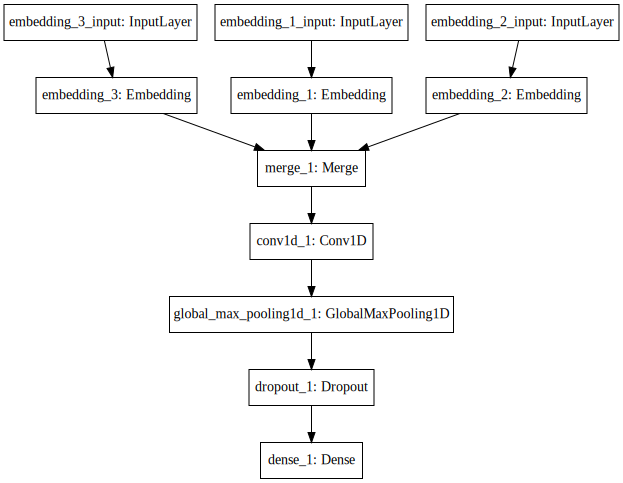

In [9]:
distanceModel1 = Sequential()
distanceModel1.add(Embedding(max_position, position_dims, input_length=positionTrain1.shape[1]))

distanceModel2 = Sequential()
distanceModel2.add(Embedding(max_position, position_dims, input_length=positionTrain2.shape[1]))

wordModel = Sequential()
wordModel.add(Embedding(embeddings.shape[0], embeddings.shape[1], input_length=sentenceTrain.shape[1], weights=[embeddings], trainable=False))


model = Sequential()
model.add(Merge([wordModel, distanceModel1, distanceModel2], mode='concat'))


model.add(Convolution1D(nb_filter=nb_filter,
                        filter_length=filter_length,
                        border_mode='same',
                        activation='tanh',
                        subsample_length=1))
# we use standard max over time pooling
model.add(GlobalMaxPooling1D())

model.add(Dropout(0.25))
model.add(Dense(n_out, activation='softmax'))


model.compile(loss='categorical_crossentropy',optimizer='Adam', metrics=['accuracy'])
model.summary()
SVG(model_to_dot(model).create(prog='dot', format='svg'))

In [10]:
print "Start training"
max_prec, max_rec, max_acc, max_f1 = 0,0,0,0
for epoch in xrange(nb_epoch):      
    print epoch
    model.fit([sentenceTrain, positionTrain1, positionTrain2], train_y_cat, batch_size=batch_size, verbose=True,nb_epoch=1)   
    pred_test = model.predict_classes([sentenceTest, positionTest1, positionTest2], verbose=False)
    
    dctLabels = np.sum(pred_test)
    totalDCTLabels = np.sum(yTest)
   
    acc =  np.sum(pred_test == yTest) / float(len(yTest))
    max_acc = max(max_acc, acc)
    print "Accuracy: %.4f (max: %.4f)" % (acc, max_acc)

    f1Sum = 0
    f1Count = 0
    for targetLabel in xrange(min(yTest), max(yTest) + 1):        
        prec = getPrecision(pred_test, yTest, targetLabel)
        rec = getPrecision(yTest, pred_test, targetLabel)
        f1 = 0 if (prec+rec) == 0 else 2*prec*rec/(prec+rec)
        f1Sum += f1
        f1Count +=1    
        
        
    macroF1 = f1Sum / float(f1Count)    
    max_f1 = max(max_f1, macroF1)
    print "Non-other Macro-Averaged F1: %.4f (max: %.4f)\n" % (macroF1, max_f1)

Start training
0


/anaconda/lib/python2.7/site-packages/keras/models.py:848: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '


Epoch 1/1
24301/24301 [==============================] - 6s - loss: 0.4188 - acc: 0.8675       

In [11]:
count = 0
for idx in range(len(pred_test)):
    #print pred_test[idx], yTest[idx]
    if pred_test[idx] == yTest[idx]:
        count += 1
        
print count, len(pred_test)

f1Sum = 0
f1Count = 0
for targetLabel in xrange(min(yTest), max(yTest) + 1):        
    prec = getPrecision(pred_test, yTest, targetLabel)
    rec = getPrecision(yTest, pred_test, targetLabel)
    f1 = 0 if (prec+rec) == 0 else 2*prec*rec/(prec+rec)
    f1Sum += f1
    f1Count +=1    


macroF1 = f1Sum / float(f1Count) 
print macroF1

1522 1778
0.340148038805


In [12]:
pred_train = model.predict_classes([sentenceTrain, positionTrain1, positionTrain2], verbose=False)
count = 0
for idx in range(len(pred_train)):
    #print pred_test[idx], yTest[idx]
    if pred_train[idx] == yTrain[idx]:
        count += 1
print count, len(pred_train)

f1Sum = 0
f1Count = 0
for targetLabel in xrange(min(yTrain), max(yTrain) + 1):        
    prec = getPrecision(pred_train, yTrain, targetLabel)
    rec = getPrecision(yTrain, pred_train, targetLabel)
    f1 = 0 if (prec+rec) == 0 else 2*prec*rec/(prec+rec)
    f1Sum += f1
    f1Count +=1    


macroF1 = f1Sum / float(f1Count) 
print macroF1

24277 24301
0.993252358266
